# This Notebook contains a standard pytorch workflow

It is not a strict guideline and can be changed as needed, however it is a good outline of what a typical workflow in pytorch will look like.

In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn

# Step 1: Loading and Preparing Data

We need to load our data as numbers so it can be represented with a pytorch tensor. We can use any type of data as long as it can be transformed into numbers. For now we will create our own data by creating a linear regression (straight line) and then trying to estimate it in pytorch.

In [5]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Cross Validation

In [6]:
train_split = .8 * len(X)
x_train, y_train = X[:int(train_split)], y[:int(train_split)]
x_test, y_test = X[int(train_split):], y[int(train_split):]


Now let's create a visualization function

In [7]:
def plot_pred(train_data=x_train, train_labels=y_train, test_data=x_test, test_labels=y_test, pred=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')
    if pred != None:
        plt.scatter(test_data, pred, c='r', label='Predictions')
    plt.legend(prop={'size': 14})

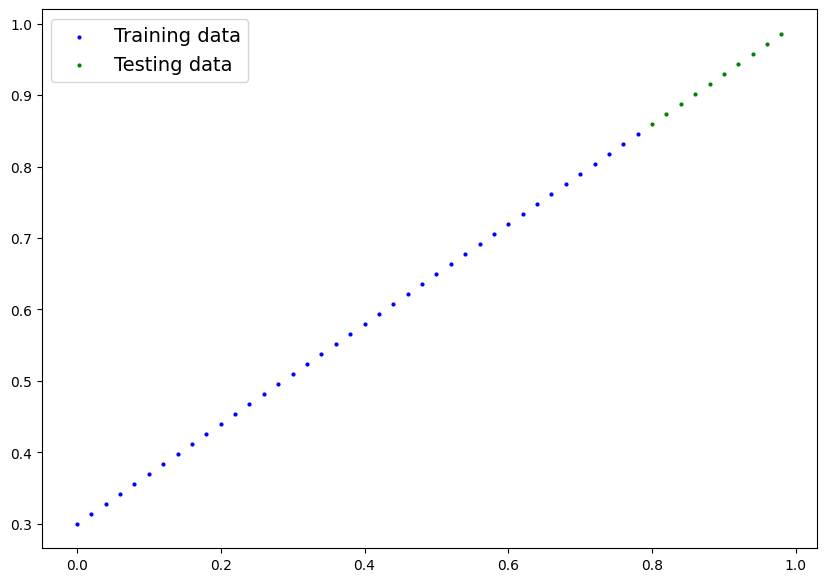

In [8]:
plot_pred()

Now let's create a standard linear regression model in pytorch

In [9]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True)) #initialize weights and biases with random value
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))
        #implement forward pass
    def forward(self, x: torch.Tensor):
        return self.weights * x + self.bias

What is going on up there?

`torch.nn`: contains all of the building blocks for computational graphs (connected neurons)

`torch.nn.Module` : The base class for any neural net, all neural nets that you build will be a subclass of nn.Module, it also requires a `forward()` function to be implemented (and a backward function to be optimized)

`forward()`: The function that passes the data from one node to another. It will define some computation (Logistic Regression, Naive Bayes, Linear Regression, etc.) that transforms the data that will then be passed to the next node it is connected to. The forward function works on the `nn.Parameter`s

`torch.nn.Parameter`: This is how we store tensors within `torch.nn.Module`. if requires_grad is set to true it will automatically calculate the gradient for updating parameters with gradient descent (autograd). The different parameters make up the `nn.Module` class. 

`torch.optim`: Contains different optimization algorithms for Gradient Descent

`torch.utils.data.Dataset`, and `torch.utils.data.DataLoader` are used to transform datasets to pytorch tensors and load them into the `nn.Module` class



In [10]:
torch.manual_seed(42)
model = LinearRegression()
#look at the parameters of the model (these are randomly initialized and can be changed by changing the random seed)
print(list(model.parameters()))
#we can also look at the state_dict of the model
print(model.state_dict())

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


### Making predictions with our model

In [11]:
with torch.inference_mode():
    pred = model(x_test)
#look at our predicitons on our testing data
print(pred)

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


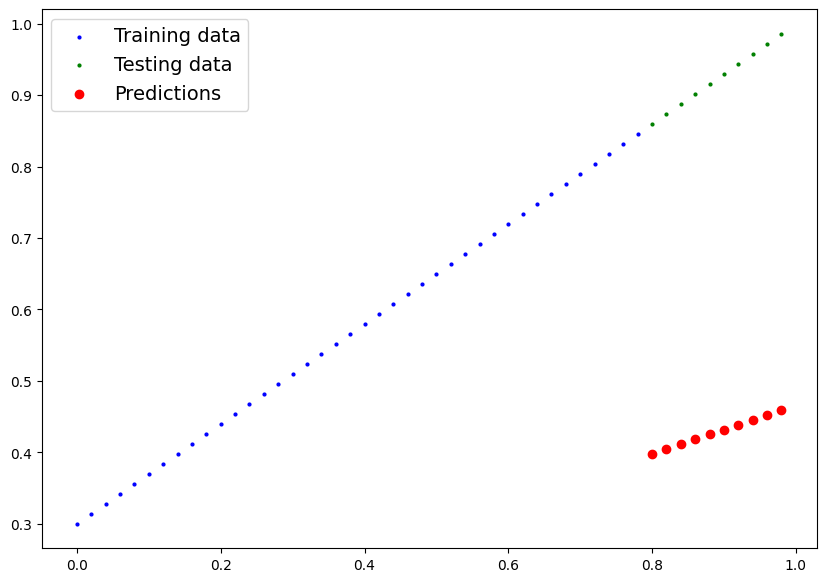

In [12]:
plot_pred(pred=pred.detach())

These predictions are pretty garbage, as our model hasn't been trained on any data yet and is randomly making predictions based off the random intializations it was given. Now we need to train our model by updating our parameters. We need two things to do this:

1) a loss function that tells us how far off our predictions are
2) an optimization function that minimizes our loss function by adjusting our parameters

In [13]:
loss_func = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)

Now we are ready to implement our pytorch training loop!
the basic steps are as follows: 
1) forward pass
2) calculate loss
3) zero out the gradients
4) backpropagation
5) Update the optimizer

This is a basic iteration of the loop, however the loop is flexible and the order above is not set in stone but there are some basic rules you should follow
- Always calculate loss before backpropagation
- Zero gradients before stepping them
- Step the optimizer after performing backpropagation

A basic pytorch testing loop looks like this:
1) Forward pass
2) Calculate loss
3) Calculate evaluation metrics

# Now Put it into code!

In [14]:
def train_loop(model, x_train, y_train, x_test, y_test, loss_func, optimizer, epochs=100):
    train_loss_vals = []
    test_loss_vals = []
    epoch_count = []
    for epoch in range(epochs):
        ### Training Loop
        #1) put model into training mode
        model.train()
        #2) forward pass
        y_pred = model(x_train)
        #3) calculate loss
        loss = loss_func(y_pred, y_train)
        #4) zero gradients
        optimizer.zero_grad()
        #5) backpropagation
        loss.backward()
        #6) update weights and biases
        optimizer.step()
        ### Testing Loop
        #1) put model into evaluation
        model.eval()
        #2) forward pass
        with torch.inference_mode():
            test_pred = model(x_test)
        #3) calculate loss
        test_loss = loss_func(test_pred, y_test.type(torch.float)) #make sure to cast y_test to float so it matches the predictions datatype as pytorch defaults to float32 datatype for predictions
        ### print what's happening every 10 epochs
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_vals.append(loss.detach().numpy())
            test_loss_vals.append(test_loss.detach().numpy())
            print(f'Epoch {epoch} | train loss: {loss} | test loss: {test_loss}')


In [15]:
train_loop(model, x_train, y_train, x_test, y_test, loss_func, optimizer, epochs=100)

Epoch 0 | train loss: 0.31288138031959534 | test loss: 0.48106518387794495
Epoch 10 | train loss: 0.1976713240146637 | test loss: 0.3463551998138428
Epoch 20 | train loss: 0.08908725529909134 | test loss: 0.21729660034179688
Epoch 30 | train loss: 0.053148526698350906 | test loss: 0.14464017748832703
Epoch 40 | train loss: 0.04543796554207802 | test loss: 0.11360953003168106
Epoch 50 | train loss: 0.04167863354086876 | test loss: 0.09919948130846024
Epoch 60 | train loss: 0.03818932920694351 | test loss: 0.08886633068323135
Epoch 70 | train loss: 0.03476089984178543 | test loss: 0.0805937647819519
Epoch 80 | train loss: 0.03132382780313492 | test loss: 0.07232122868299484
Epoch 90 | train loss: 0.02788739837706089 | test loss: 0.06473556160926819


# Making predictions
Now that we have a trained model we can start to make predictions with it.

There are 3 important things to remember when making predictions with a model
1) set the model to evaluation mode `model.eval`
2) make predictions using inference mode in pytorch `with torch.inference_mode():`
3) All predictions should be made on objects with the same device (all on GPU or CPU)

Let's see what this looks like in code

In [16]:
#set model to evaluation mode
model.eval()
#use inference mode to make predictions
with torch.inference_mode():
    pred = model(x_test)
print(pred)

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])


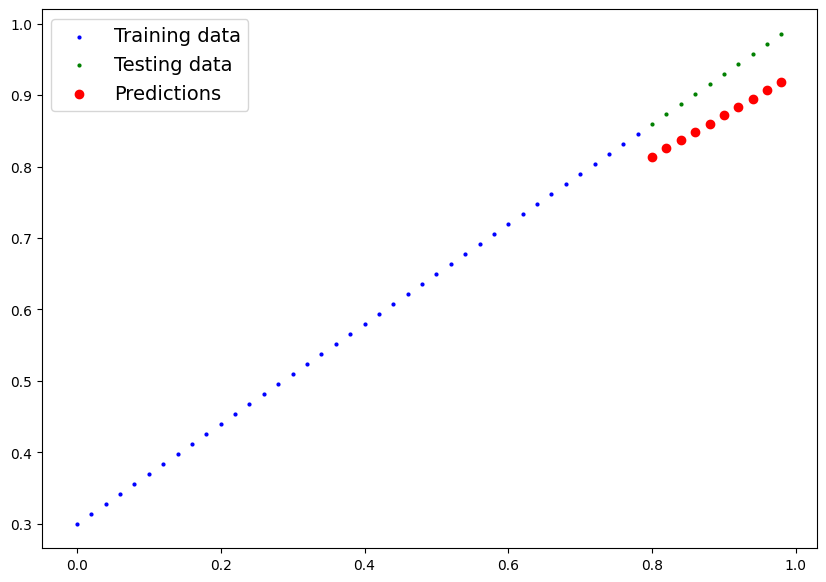

In [17]:
plot_pred(pred=pred)

Now our predictions are much closer to our testing data, with a little more training we could probably get it right on the money (at least for this simple problem)

In [18]:
train_loop(model, x_train, y_train, x_test, y_test, loss_func, optimizer, epochs=1000)

Epoch 0 | train loss: 0.024458957836031914 | test loss: 0.05646304413676262
Epoch 10 | train loss: 0.021020207554101944 | test loss: 0.04819049686193466
Epoch 20 | train loss: 0.01758546568453312 | test loss: 0.04060482233762741
Epoch 30 | train loss: 0.014155393466353416 | test loss: 0.03233227878808975
Epoch 40 | train loss: 0.010716589167714119 | test loss: 0.024059748277068138
Epoch 50 | train loss: 0.0072835334576666355 | test loss: 0.016474086791276932
Epoch 60 | train loss: 0.0038517764769494534 | test loss: 0.008201557211577892
Epoch 70 | train loss: 0.008932482451200485 | test loss: 0.005023092031478882
Epoch 80 | train loss: 0.008932482451200485 | test loss: 0.005023092031478882
Epoch 90 | train loss: 0.008932482451200485 | test loss: 0.005023092031478882
Epoch 100 | train loss: 0.008932482451200485 | test loss: 0.005023092031478882
Epoch 110 | train loss: 0.008932482451200485 | test loss: 0.005023092031478882
Epoch 120 | train loss: 0.008932482451200485 | test loss: 0.005023

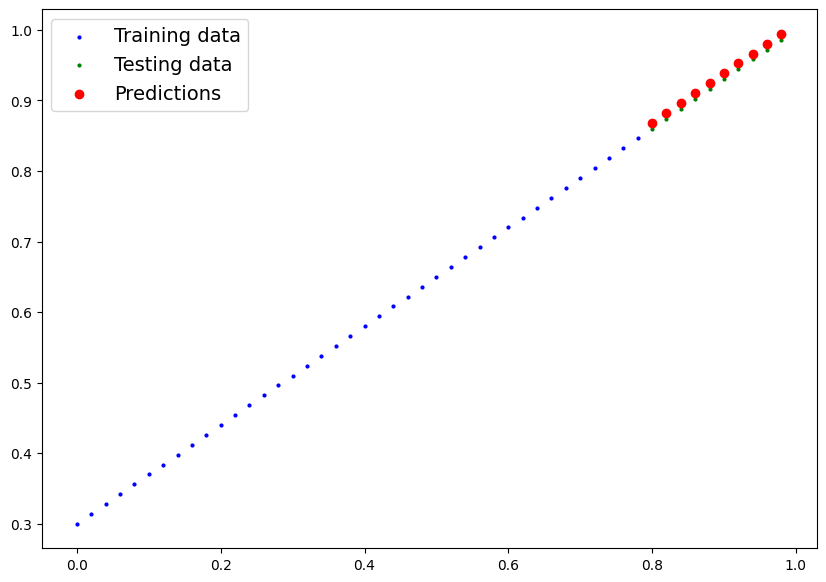

In [19]:
model.eval()
with torch.inference_mode():
    pred = model(x_test)
plot_pred(pred=pred)

Even better! Now let's look at how we can save our model for later use

There are a couple different ways to do this. But before we get started on that, let's create a directory for our models with pathlib

In [20]:
from pathlib import Path
#first create a directory to save our model
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,exist_ok=True)

#Now create a model save path
MODEL_NAME = 'linear_regression_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Save the model state dict
print(f"Saving model state dict at {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model state dict at models/linear_regression_model.pth


Now that our model's state dictionary is saved let's load it using the pytorch state dict loading module

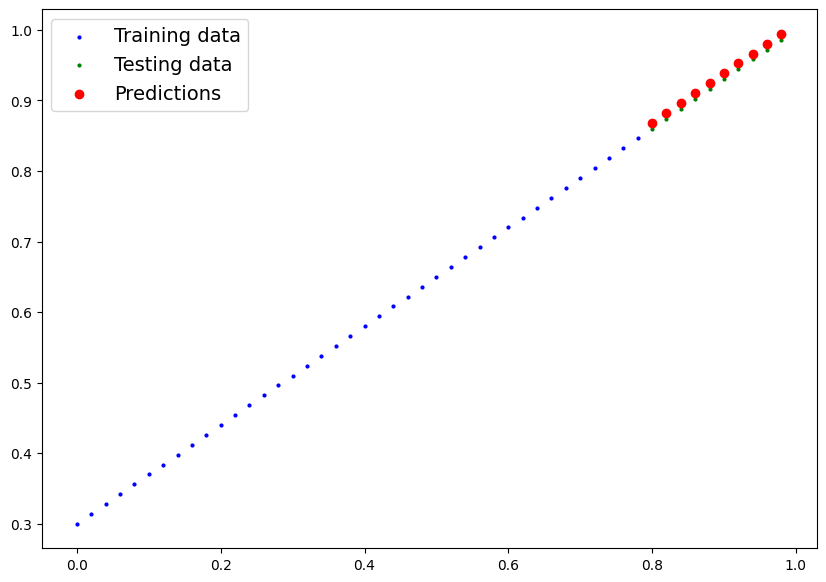

In [25]:
#Load the model we are using (should match the same model as the saved state_dict)
load_model = LinearRegression()
#load the state_dict with .load_state_dict() and the path to the saved model state_dict
load_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
#make predictions with the loaded model the same as before
load_model.eval()
with torch.inference_mode():
    pred = load_model(x_test)
plot_pred(pred=pred)